eCommerce-Preprocess

Reads csv file,
Corrects schema, Removes Nulls and then
Saves as parquet file

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/Shareddrives/DA231-2022-public/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

Mounted at /content/drive


In [3]:
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder\
         .master("local[*]")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
spark

In [ ]:
### IMPORTS ###
from pyspark.sql.functions import sum,col,split,expr,concat,concat_ws,lit,to_date
from pyspark.sql.types import FloatType, TimestampType

In [ ]:
### CONFIG ###

#year_month={"2019":["10","11","12"], "2020":["01","02","03","04"]}
year_month={"2019":["10","11"]}
raw_data_files = [#"/content/drive/Shareddrives/FourYottaBytes_DA231o/2019-Nov.csv",\
                  "/content/drive/Shareddrives/FourYottaBytes_DA231o/2019-Oct.csv",\
                  "/content/drive/Shareddrives/FourYottaBytes_DA231o/2019_Dec.csv",\
                  "/content/drive/Shareddrives/FourYottaBytes_DA231o/2020-Jan.csv",\
                  "/content/drive/Shareddrives/FourYottaBytes_DA231o/2020-Feb.csv",\
                  "/content/drive/Shareddrives/FourYottaBytes_DA231o/2020-Mar.csv",\
                  "/content/drive/Shareddrives/FourYottaBytes_DA231o/2020-Apr.csv"]
output_parquet_save_path="/content/drive/Shareddrives/FourYottaBytes_DA231o/eCommerce/"

In [ ]:
### ETL-PREPROCESSING ###

#This method reads the given csv into a dataframe
def extractFromCSV(input_file):
    df=spark.read.option("header","true").csv(input_file)
    return df

#This method corrects the schema and does some transformations
#*********Nulls are dropped and the reason is drafted below with the explanation
def preprocessData(df):
  dfSchemaChange=df.withColumn("event_time",col("event_time").cast(TimestampType()))\
        .withColumn("price",col("price").cast(FloatType()))\
        .withColumn("date",to_date(col("event_time")))\
        .select("event_time","date","event_type","product_id","category_id","category_code","brand","price","user_id","user_session").na.drop(how="any")  
  return dfSchemaChange

#This method loads the dataframe as a parquet file at the specified location
def loadAsParquet(df,output_path):
  tag="schema_verified/"
  df.write.mode('append').partitionBy("date").parquet(output_path+tag)

In [ ]:
#Helper module for ETL functions
def etlRunner():
  for f in raw_data_files:
    extracted_df=extractFromCSV(input_file=f)
    transformed_df=preprocessData(extracted_df)
    loadAsParquet(transformed_df,output_parquet_save_path)

In [ ]:
#etlRunner()

The total parquet size for 7 months is approx 11GB

In [ ]:
#Command to check the size of the contents of the folder
!du -h /content/drive/Shareddrives/FourYottaBytes_DA231o/eCommerce/schema_verified

Reference for reading the parquet files for analysis

In [ ]:
#Sample parquet read for selected year and months
dfp=[]
for year, months in year_month.items():
  for month in months:
    path="/content/drive/Shareddrives/FourYottaBytes_DA231o/eCommerce/schema_verified/date="+year+"-"+month+"*"
    print("Reading :"+path)
    df=spark.read.parquet(path)
    dfp.append(df)

total_df=dfp[0]
for i in range(1,len(dfp)):
  total_df=total_df.union(dfp[i])

Reading :/content/drive/Shareddrives/FourYottaBytes_DA231o/eCommerce/schema_verified/date=2019-10*
Reading :/content/drive/Shareddrives/FourYottaBytes_DA231o/eCommerce/schema_verified/date=2019-11*


In [ ]:
#***To read the whole data***#
#df=spark.read.parquet("/content/drive/Shareddrives/FourYottaBytes_DA231o/eCommerce/schema_verified/")

In [ ]:
total_df.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: float (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)



In [ ]:
#do cache if the data size is not too large
total_df.cache()
total_df.count()

68650184

In [ ]:
purchase_events=total_df.filter(col("event_type")=="purchase").select("event_time","product_id","category_code","brand","price","user_id","user_session")
view_events=total_df.filter(col("event_type")=="view").select("event_time","product_id","category_code","brand","price","user_id","user_session")

In [ ]:
purchase_events.show(10,False)

+-------------------+----------+--------------------------------+----------+-------+---------+------------------------------------+
|event_time         |product_id|category_code                   |brand     |price  |user_id  |user_session                        |
+-------------------+----------+--------------------------------+----------+-------+---------+------------------------------------+
|2019-10-15 05:28:47|1500448   |computers.peripherals.printer   |hp        |102.7  |560343791|001bf2c7-b99d-4ab2-9229-4fc4577c4430|
|2019-10-15 05:28:49|1002524   |electronics.smartphone          |apple     |584.31 |547322571|ea58cbb4-a3c9-4a8b-b3c7-5da9eefdb1e6|
|2019-10-15 05:28:58|1307135   |computers.notebook              |hp        |262.3  |526933626|555b48f8-1723-4792-8ef5-9f8e99e5b2f7|
|2019-10-15 05:29:03|1801911   |electronics.video.tv            |samsung   |1001.0 |515276384|fb4e73af-1a86-4238-8688-f8a5dcadf29b|
|2019-10-15 05:29:08|1005205   |electronics.smartphone          |oppo      |

In [ ]:
view_events.show(10,False)

+-------------------+----------+---------------------------------+-------+------+---------+------------------------------------+
|event_time         |product_id|category_code                    |brand  |price |user_id  |user_session                        |
+-------------------+----------+---------------------------------+-------+------+---------+------------------------------------+
|2019-10-15 05:28:44|1004767   |electronics.smartphone           |samsung|250.82|544901563|09f4b086-0a1d-41dd-b59c-49c9c89056fd|
|2019-10-15 05:28:44|1307135   |computers.notebook               |hp     |262.3 |526933626|555b48f8-1723-4792-8ef5-9f8e99e5b2f7|
|2019-10-15 05:28:44|1005186   |electronics.smartphone           |samsung|771.94|560339851|e5621b84-632b-41fc-9cc5-0c4cb5d699bc|
|2019-10-15 05:28:44|10900003  |appliances.kitchen.mixer         |polaris|40.85 |560346118|e598dff3-e5b5-4c4d-b603-42259d0ddde1|
|2019-10-15 05:28:45|1004249   |electronics.smartphone           |apple  |766.76|516748661|6c8cd2

Top viewed vs Purchased brands

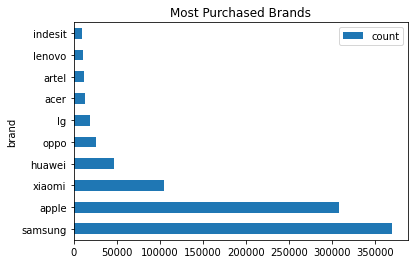

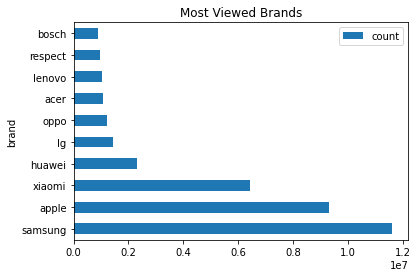

In [ ]:
purchase_events.groupBy("brand").count().orderBy("count",ascending=False).limit(10).toPandas().plot.barh(x='brand', y='count',title="Most Purchased Brands")
view_events.groupBy("brand").count().orderBy("count",ascending=False).limit(10).toPandas().plot.barh(x='brand', y='count',title="Most Viewed Brands")

Top Viewed vs Purchased Categories

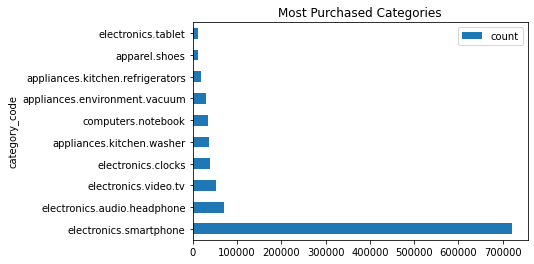

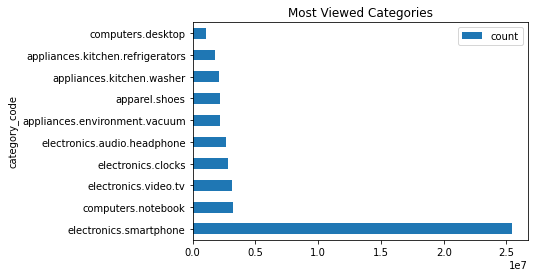

In [ ]:
purchase_events.groupBy("category_code").count().orderBy("count",ascending=False).limit(10).toPandas().plot.barh(x='category_code', y='count',title="Most Purchased Categories")
view_events.groupBy("category_code").count().orderBy("count",ascending=False).limit(10).toPandas().plot.barh(x='category_code', y='count',title="Most Viewed Categories")  

In [ ]:
top10purchasedbrands=purchase_events.groupBy("brand").count().orderBy("count",ascending=False).limit(10).select("brand").rdd.flatMap(lambda x: x).collect()
top10purchasedCategory_code=purchase_events.groupBy("category_code").count().orderBy("count",ascending=False).limit(10).select("category_code").rdd.flatMap(lambda x: x).collect()

In [ ]:
print(top10purchasedbrands)
print(top10purchasedCategory_code)


['samsung', 'apple', 'xiaomi', 'huawei', 'oppo', 'lg', 'acer', 'artel', 'lenovo', 'indesit']
['electronics.smartphone', 'electronics.audio.headphone', 'electronics.video.tv', 'electronics.clocks', 'appliances.kitchen.washer', 'computers.notebook', 'appliances.environment.vacuum', 'appliances.kitchen.refrigerators', 'apparel.shoes', 'electronics.tablet']


Daily trend of Product Views and Purchases by Top-10 purchased Brands

In [ ]:
top10purchase_dailyCount=purchase_events.filter(col("brand").isin(top10purchasedbrands)).withColumn("date",to_date(col("event_time"))).groupBy("date","brand").count().toPandas().pivot(index='date', columns='brand', values='count')

In [ ]:
top10purchasedItemsViews_dailyCount=view_events.filter(col("brand").isin(top10purchasedbrands)).withColumn("date",to_date(col("event_time"))).groupBy("date","brand").count().toPandas().pivot(index='date', columns='brand', values='count')

In [ ]:
t10purchased_viewcounts=view_events.filter(col("brand").isin(top10purchasedbrands)).withColumn("date",to_date(col("event_time"))).groupBy("date","brand").count().withColumn("view_count",col("count")).drop("count")
t10purchasedcounts=purchase_events.filter(col("brand").isin(top10purchasedbrands)).withColumn("date",to_date(col("event_time"))).groupBy("date","brand").count().withColumn("purchase_count",col("count")).drop("count")
viewVspurchase=t10purchased_viewcounts.join(t10purchasedcounts,["date","brand"]).withColumn("purchase_view_ratio",col("purchase_count")/col("view_count")).drop("view_count","purchase_count").toPandas().pivot(index='date', columns='brand', values='purchase_view_ratio')

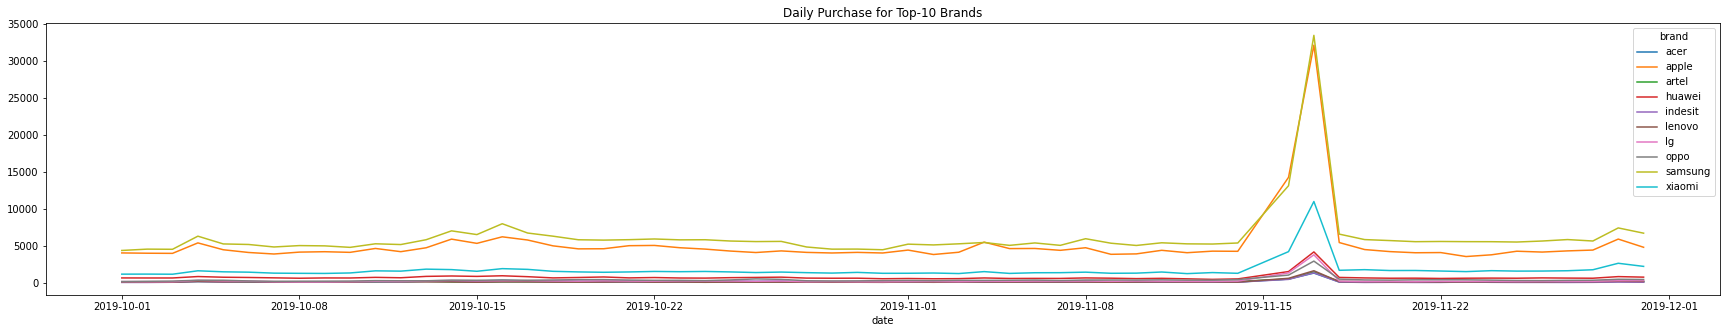

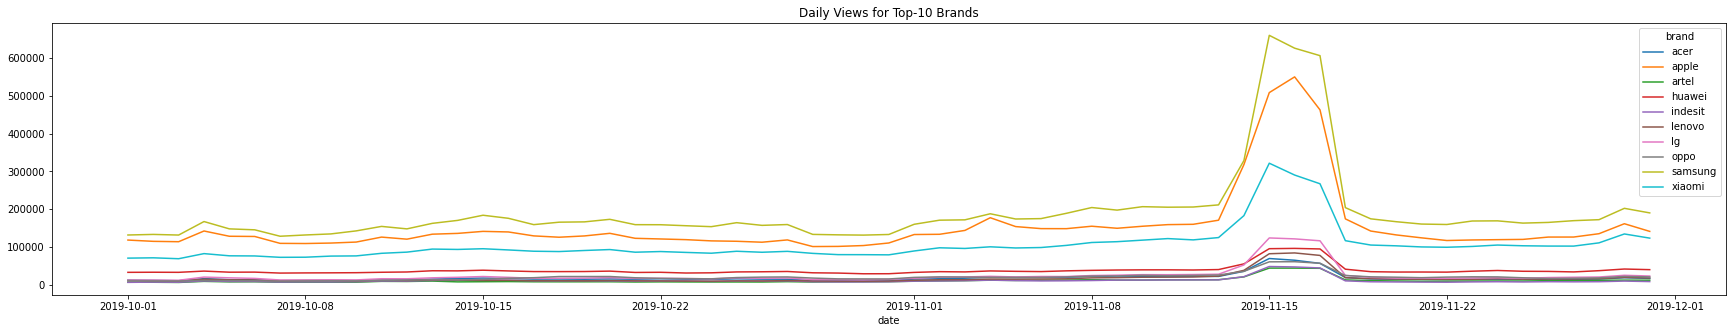

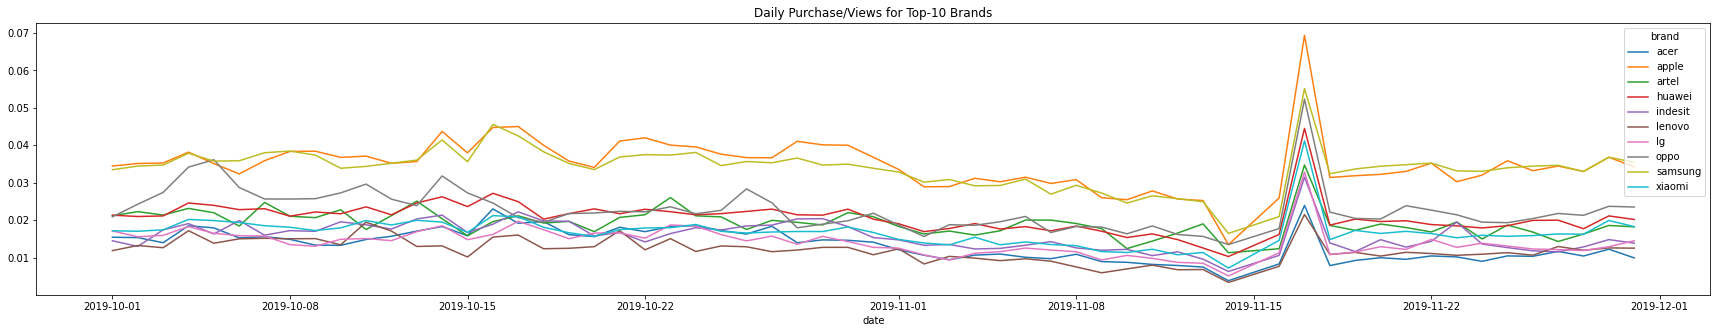

In [ ]:
top10purchase_dailyCount.plot(figsize=(30, 5), title="Daily Purchase for Top-10 Brands")
top10purchasedItemsViews_dailyCount.plot(figsize=(30, 5),title="Daily Views for Top-10 Brands")
viewVspurchase.plot(figsize=(30, 5),title="Daily Purchase/Views for Top-10 Brands")

Daily trend of Product Views and Purchases by Top-10 purchased Categories

In [ ]:
top10purchase_dailyCountC=purchase_events.filter(col("category_code").isin(top10purchasedCategory_code)).withColumn("date",to_date(col("event_time"))).groupBy("date","category_code").count().toPandas().pivot(index='date', columns='category_code', values='count')
top10purchasedItemsViews_dailyCountC=view_events.filter(col("category_code").isin(top10purchasedCategory_code)).withColumn("date",to_date(col("event_time"))).groupBy("date","category_code").count().toPandas().pivot(index='date', columns='category_code', values='count')
t10purchased_viewcountsC=view_events.filter(col("category_code").isin(top10purchasedCategory_code)).withColumn("date",to_date(col("event_time"))).groupBy("date","category_code").count().withColumn("view_count",col("count")).drop("count")
t10purchasedcountsC=purchase_events.filter(col("category_code").isin(top10purchasedCategory_code)).withColumn("date",to_date(col("event_time"))).groupBy("date","category_code").count().withColumn("purchase_count",col("count")).drop("count")
viewVspurchaseC=t10purchased_viewcountsC.join(t10purchasedcountsC,["date","category_code"]).withColumn("purchase_view_ratio",col("purchase_count")/col("view_count")).drop("view_count","purchase_count").toPandas().pivot(index='date', columns='category_code', values='purchase_view_ratio')

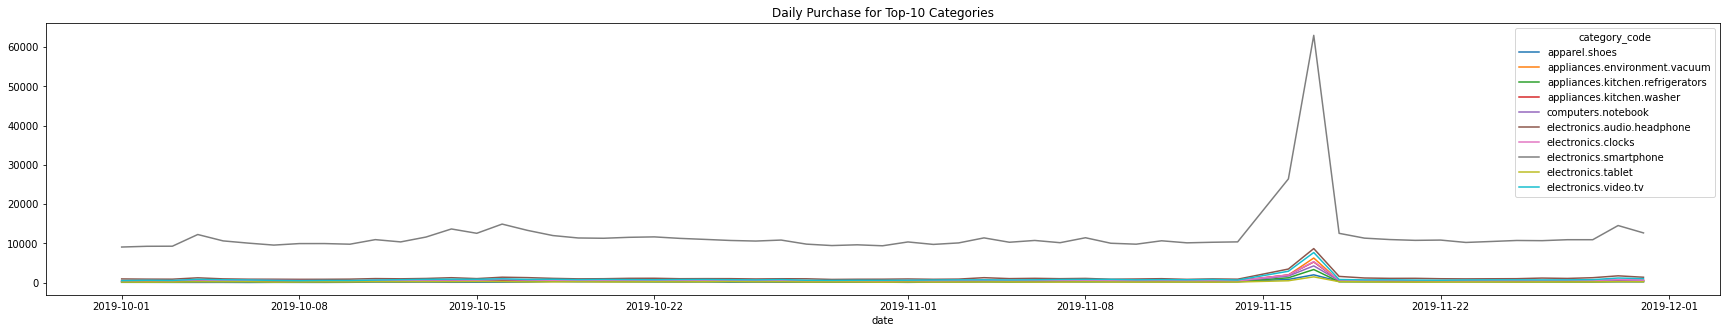

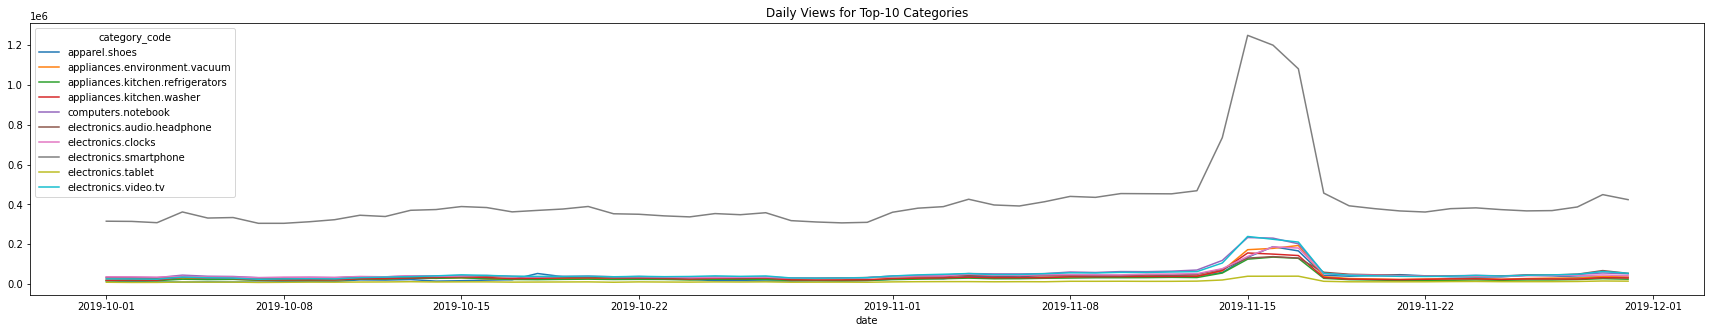

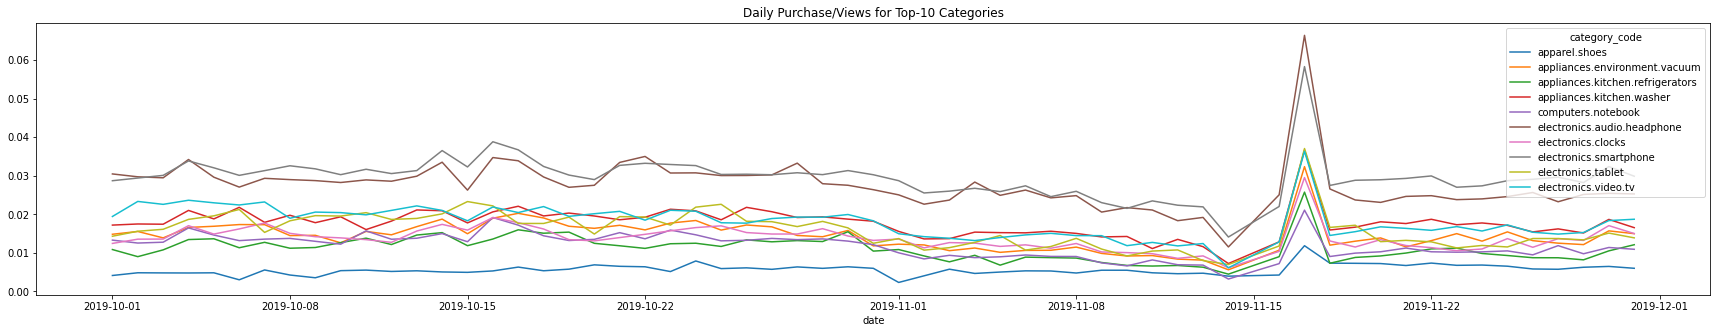

In [ ]:
top10purchase_dailyCountC.plot(figsize=(30, 5), title="Daily Purchase for Top-10 Categories")
top10purchasedItemsViews_dailyCountC.plot(figsize=(30, 5),title="Daily Views for Top-10 Categories")
viewVspurchaseC.plot(figsize=(30, 5),title="Daily Purchase/Views for Top-10 Categories")

In [ ]:
#Extracting the gz files
!gzip -d /content/drive/Shareddrives/FourYottaBytes_DA231o/2019_Dec.csv.gz
!gzip -d /content/drive/Shareddrives/FourYottaBytes_DA231o/2020-Jan.csv.gz
!gzip -d /content/drive/Shareddrives/FourYottaBytes_DA231o/2020-Feb.csv.gz
!gzip -d /content/drive/Shareddrives/FourYottaBytes_DA231o/2020-Mar.csv.gz
!gzip -d /content/drive/Shareddrives/FourYottaBytes_DA231o/2020-Apr.csv.gz

Rough work for deciding whether null category_codes should be replaced with some value or dropped.

The category_code -> category_id mapping is "1 to m" with null code having most ids but the mapping category_id -> category_code is 1 to 1. This implies that a null code can not be replaced with another value.

In [ ]:
df=spark.read.option("header","true").csv("/content/drive/Shareddrives/FourYottaBytes_DA231o/2019-Nov.csv")

In [ ]:
df.select("category_id").distinct().count()

684

In [ ]:
df.select("category_code").distinct().count()

130

In [ ]:
df.select("category_id","category_code").distinct().groupBy("category_code").count().orderBy("count",ascending=False).show(130,False)

+--------------------------------------+-----+
|category_code                         |count|
+--------------------------------------+-----+
|null                                  |409  |
|apparel.shoes                         |26   |
|apparel.shoes.keds                    |8    |
|apparel.costume                       |8    |
|accessories.bag                       |7    |
|apparel.shirt                         |6    |
|sport.bicycle                         |6    |
|apparel.trousers                      |5    |
|apparel.shoes.sandals                 |5    |
|construction.tools.saw                |4    |
|apparel.shoes.moccasins               |4    |
|furniture.living_room.cabinet         |4    |
|furniture.kitchen.table               |4    |
|appliances.environment.vacuum         |4    |
|computers.desktop                     |4    |
|sport.trainer                         |4    |
|electronics.clocks                    |4    |
|apparel.tshirt                        |4    |
|construction

In [ ]:
df.show(10,False)


+-----------------------+----------+----------+-------------------+-------------------------+--------+------+---------+------------------------------------+
|event_time             |event_type|product_id|category_id        |category_code            |brand   |price |user_id  |user_session                        |
+-----------------------+----------+----------+-------------------+-------------------------+--------+------+---------+------------------------------------+
|2019-11-01 00:00:00 UTC|view      |1003461   |2053013555631882655|electronics.smartphone   |xiaomi  |489.07|520088904|4d3b30da-a5e4-49df-b1a8-ba5943f1dd33|
|2019-11-01 00:00:00 UTC|view      |5000088   |2053013566100866035|appliances.sewing_machine|janome  |293.65|530496790|8e5f4f83-366c-4f70-860e-ca7417414283|
|2019-11-01 00:00:01 UTC|view      |17302664  |2053013553853497655|null                     |creed   |28.31 |561587266|755422e7-9040-477b-9bd2-6a6e8fd97387|
|2019-11-01 00:00:01 UTC|view      |3601530   |20530135638

In [ ]:
#create a subset data
dfp.sample(None,0.1,123).count()

4209070

In [ ]:
dfp.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in dfp.columns)).show()

+----------+----------+----------+-----------+-------------+------------+-----+-----+-------+------------+
|event_time|event_type|product_id|category_id|main_category|sub_category|brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+------------+-----+-----+-------+------------+
|         0|         0|         0|          0|            0|           0|    0|    0|      0|           0|
+----------+----------+----------+-----------+-------------+------------+-----+-----+-------+------------+



In [ ]:
dfp.filter(col("main_category").isNull() & col("event_type").isin("purchase")).show(10,False)

+----------+----------+----------+-----------+-------------+------------+-----+-----+-------+------------+
|event_time|event_type|product_id|category_id|main_category|sub_category|brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+------------+-----+-----+-------+------------+
+----------+----------+----------+-----------+-------------+------------+-----+-----+-------+------------+



In [ ]:
dfp.select("product_id","category_id").distinct().groupBy("category_id").count().orderBy("count",ascending=False).show(10,False)

+-------------------+-----+
|category_id        |count|
+-------------------+-----+
|2053013561579406073|5420 |
|2053013554658804075|2145 |
|2053013557343158789|1971 |
|2070005009382114061|1905 |
|2053013560346280633|1583 |
|2053013558920217191|1507 |
|2053013563743667055|1405 |
|2053013555631882655|1335 |
|2053013565639492569|1295 |
|2053013563877884791|1217 |
+-------------------+-----+
only showing top 10 rows



In [ ]:
 dfp.select("main_category").distinct().show()

+-------------+
|main_category|
+-------------+
|     medicine|
|    computers|
|         auto|
|   stationery|
|        sport|
|      apparel|
|   appliances|
| country_yard|
|    furniture|
|  accessories|
|         kids|
|  electronics|
| construction|
+-------------+



In [ ]:
df.select("category_code").distinct().count()

130

In [ ]:
df.filter(df["event_type"]=="purchase").select("product_id","price").count()

916939

In [ ]:
df.filter(df["event_type"]=="purchase").select("user_id","price").withColumn("priceNum", col("price").cast(FloatType())).drop("price").groupBy("user_id").sum().orderBy("sum(priceNum)", ascending=False).show(10)

+---------+------------------+
|  user_id|     sum(priceNum)|
+---------+------------------+
|518514099| 203986.0684967041|
|512386086|161682.48834991455|
|564068124|131929.20016098022|
|515715331|117130.12017822266|
|521230795|111072.34990692139|
|549109608|106692.02017974854|
|569333570| 99622.06025505066|
|512842822| 97475.35104370117|
|515384420| 92394.47001647949|
|545743740| 91858.16102910042|
+---------+------------------+
only showing top 10 rows



In [5]:
df=spark.read.parquet("/content/drive/Shareddrives/FourYottaBytes_DA231o/eCommerce/compoundAnalysisResources/user_history_store/1/")

In [12]:
df.show(5,True)

+---------+----------+-----------+------------------+------------------+--------------------+--------------------+
|  user_id|event_type|event_count|   avg_event_price|            stddev|       event_history|     product_history|
+---------+----------+-----------+------------------+------------------+--------------------+--------------------+
|512370084|  purchase|          1|  94.9800033569336|               0.0|             [94.98]|          [17300136]|
|512370084|      cart|          2|  94.9800033569336|               0.0|      [94.98, 94.98]|          [17300136]|
|512370084|      view|          4|465.32500076293945|488.18483152851655|[1285.49, 385.85,...|          [17300136]|
|512399877|  purchase|          6| 1434.518330891927|139.26739369014393|[1376.87, 1541.87...|[1005105, 1005124...|
|512399877|      view|         20|   1448.9830078125|173.77757957282486|[1376.87, 1376.87...|[1005105, 1005124...|
+---------+----------+-----------+------------------+------------------+--------

In [13]:
df=spark.read.parquet("/content/drive/Shareddrives/FourYottaBytes_DA231o/eCommerce/compoundAnalysisResources/catalog_store/1/")

In [14]:
df.show(5,True)

+----------+----------+-----------+------------------+--------------------+---------+
|product_id|event_type|event_count|         avg_price|       category_code|    brand|
+----------+----------+-----------+------------------+--------------------+---------+
| 100000181|      view|          1|25.350000381469727|electronics.telep...|milavitsa|
| 100000743|      view|          1|24.450000762939453|           kids.toys|     vega|
| 100001988|      view|       1773| 98.54140423583985|electronics.audio...|   adagio|
| 100001988|  purchase|         23| 98.54140423583985|electronics.audio...|   adagio|
| 100001988|      cart|         79| 98.54140423583985|electronics.audio...|   adagio|
+----------+----------+-----------+------------------+--------------------+---------+
only showing top 5 rows

